In [1]:
from keras.datasets import imdb
from keras.utils import pad_sequences
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import ParameterGrid
from keras.callbacks import EarlyStopping

In [2]:
(x_train, y_train), (x_test, y_test) = imdb.load_data()

17464789/17464789 [==============================] - 0s 0us/step


In [3]:
print(x_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [4]:
#As it clear, the text of reviews is integer-encoded, where each integer represents a specific word in the dictionary.
#We can convert the integers back to words as the following

INDEX_FROM = 3
word_index = imdb.get_word_index()
word_index = {key:(value+INDEX_FROM) for key,value in word_index.items()}
word_index["<PAD>"] = 0    # the padding token
word_index["<START>"] = 1  # the starting token
word_index["<UNK>"] = 2    # the unknown token
reverse_word_index = {value:key for key, value in word_index.items()}

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

decode_review(x_train[0])

1641221/1641221 [==============================] - 0s 0us/step


"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and sh

In [5]:
#consider the top 5000 most common words. I will also consider 20% of the training set for validation purpose.
vocab_size = 5000 
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words= vocab_size)

X_train, X_val = X_train[:-5000], X_train[-5000:]
y_train, y_val = y_train[:-5000], y_train[-5000:]

print(len(X_train), 'train sequences')
print(len(X_val), 'val sequences')
print(len(X_test), 'test sequences')

20000 train sequences
5000 val sequences
25000 test sequences


In [6]:
decode_review(X_train[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly <UNK> was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little <UNK> that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big <UNK> for the whole film but these children are amazing and should be <UNK> for what the

In [7]:
#Movie reviews can be different lengths. We will use the pad_sequences function to standardize the lengths of the reviews

maximum_sequence_length = 500 # maximum length of all review sequences

X_train = pad_sequences(X_train, value= word_index["<PAD>"], padding= 'post', maxlen= maximum_sequence_length)
X_val = pad_sequences(X_val, value= word_index["<PAD>"], padding= 'post', maxlen= maximum_sequence_length)
X_test = pad_sequences(X_test, value= word_index["<PAD>"], padding= 'post', maxlen= maximum_sequence_length)

print('X_train shape:', X_train.shape) # (n_samples, n_timesteps) , first sample have 500 word
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)

X_train shape: (20000, 500)
X_val shape: (5000, 500)
X_test shape: (25000, 500)


In [8]:
print(X_train[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
    2   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117    2   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194    2   18    4  226   22   21  134  476
   26  480    5  144   30    2   18   51   36   28  224   92   25  104
    4 

In [9]:
embedding_dim = 16

def create_model(filters = 64, kernel_size = 3, strides=1, units = 256, 
                 optimizer='adam', rate = 0.25, kernel_initializer ='glorot_uniform'):
    model = Sequential()
    # Embedding layer (500,16)
    model.add(Embedding(vocab_size, embedding_dim, input_length= maximum_sequence_length))
    # Convolutional Layer(s)
    model.add(Dropout(rate))
    model.add(Conv1D(filters = filters, kernel_size = kernel_size, strides= strides, 
                     padding='same', activation= 'relu'))
    model.add(GlobalMaxPooling1D())
    # Dense layer(s)
    model.add(Dense(units = units, activation= 'relu', kernel_initializer= kernel_initializer))
    model.add(Dropout(rate))
    # Output layer
    model.add(Dense(1, activation= 'sigmoid'))
    
    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer= optimizer,
                  metrics=['accuracy'])
    return model
# Build the model
model = KerasClassifier(build_fn= create_model)

<ipython-input-9-c1145a24d7ea>:25: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn= create_model)


In [10]:
# Set the hyperparameters
# i used this few params because i dont have colab pro to do all params
filters = [64,128] 
kernel_size = [3,5] 
strides= [1]
Dense_units = [128, 512]
kernel_initializer = ['TruncatedNormal']
rate_dropouts = [0.25] 
optimizers = ['adam','rmsprop'] 
epochs = [5]
batches = [64]
# ----------------------------------------------
# Exhaustive Grid Search
param_grid = dict(optimizer= optimizers, epochs= epochs, batch_size= batches,
                  filters = filters, kernel_size = kernel_size, strides = strides, 
                  units = Dense_units, kernel_initializer= kernel_initializer, rate = rate_dropouts)

In [11]:
grid = ParameterGrid(param_grid)
param_sets = list(grid)

param_scores = []
for params in grid:

    print(params)
    model.set_params(**params)

    earlystopper = EarlyStopping(monitor='val_accuracy', patience= 0, verbose=1)
    
    history = model.fit(X_train, y_train,
                        shuffle= True,
                        validation_data=(X_val, y_val),
                        callbacks= [earlystopper])

    param_score = history.history['val_accuracy']
    param_scores.append(param_score[-1])
    print('+-'*50) 

{'batch_size': 64, 'epochs': 5, 'filters': 64, 'kernel_initializer': 'TruncatedNormal', 'kernel_size': 3, 'optimizer': 'adam', 'rate': 0.25, 'strides': 1, 'units': 128}
Epoch 1/5
313/313 [==============================] - 13s 37ms/step - loss: 0.5962 - accuracy: 0.6456 - val_loss: 0.4033 - val_accuracy: 0.8182
Epoch 2/5
313/313 [==============================] - 11s 35ms/step - loss: 0.3393 - accuracy: 0.8552 - val_loss: 0.3136 - val_accuracy: 0.8674
Epoch 3/5
313/313 [==============================] - 11s 35ms/step - loss: 0.2702 - accuracy: 0.8874 - val_loss: 0.2961 - val_accuracy: 0.8796
Epoch 4/5
313/313 [==============================] - 12s 38ms/step - loss: 0.2298 - accuracy: 0.9108 - val_loss: 0.2782 - val_accuracy: 0.8818
Epoch 5/5
313/313 [==============================] - 11s 35ms/step - loss: 0.1956 - accuracy: 0.9256 - val_loss: 0.2896 - val_accuracy: 0.8836
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
{'batch_size': 

In [12]:
# Choose best parameters
p = np.argmax(np.array(param_scores))
print('param_scores:', param_scores)
print("best score:", param_scores[p])
best_params = param_sets[p]
print("best parameter set", best_params)


param_scores: [0.8835999965667725, 0.8867999911308289, 0.878600001335144, 0.8730000257492065, 0.894599974155426, 0.8830000162124634, 0.8424000144004822, 0.8744000196456909, 0.885200023651123, 0.8841999769210815, 0.8858000040054321, 0.8223999738693237, 0.8931999802589417, 0.8881999850273132, 0.8971999883651733, 0.9028000235557556]
best score: 0.9028000235557556
best parameter set {'batch_size': 64, 'epochs': 5, 'filters': 128, 'kernel_initializer': 'TruncatedNormal', 'kernel_size': 5, 'optimizer': 'rmsprop', 'rate': 0.25, 'strides': 1, 'units': 512}


In [13]:
model.set_params(**best_params)
history = model.fit(X_train, y_train, epochs=5,validation_data=(X_val, y_val))

Epoch 1/5
313/313 [==============================] - 23s 70ms/step - loss: 0.6126 - accuracy: 0.6377 - val_loss: 0.4458 - val_accuracy: 0.7986
Epoch 2/5
313/313 [==============================] - 21s 67ms/step - loss: 0.3748 - accuracy: 0.8344 - val_loss: 0.3289 - val_accuracy: 0.8604
Epoch 3/5
313/313 [==============================] - 20s 65ms/step - loss: 0.2890 - accuracy: 0.8814 - val_loss: 0.2851 - val_accuracy: 0.8802
Epoch 4/5
313/313 [==============================] - 21s 68ms/step - loss: 0.2500 - accuracy: 0.8992 - val_loss: 0.2657 - val_accuracy: 0.8938
Epoch 5/5
313/313 [==============================] - 21s 68ms/step - loss: 0.2274 - accuracy: 0.9098 - val_loss: 0.2707 - val_accuracy: 0.8926


In [14]:
from sklearn.metrics import accuracy_score
print("Test accuracy = %f%%" % (accuracy_score(y_test, model.predict(X_test))*100))

782/782 [==============================] - 6s 8ms/step
Test accuracy = 88.736000%


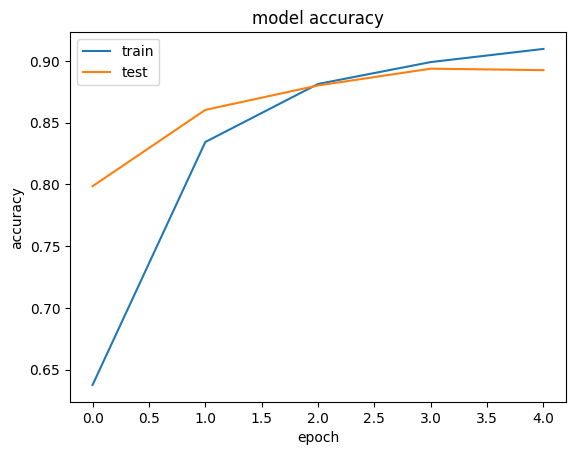

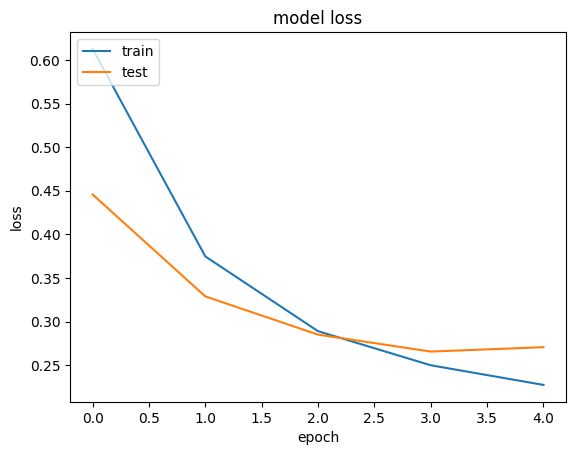

In [15]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

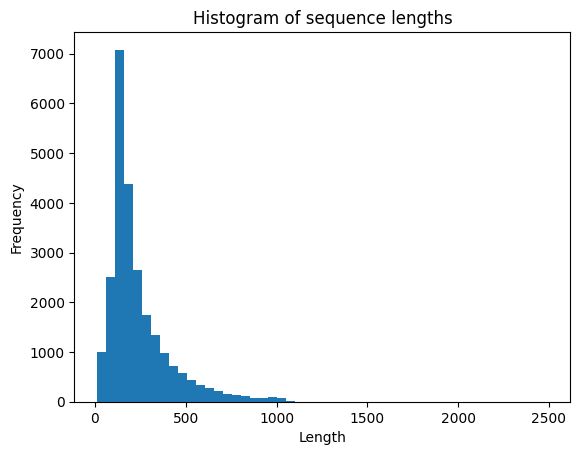

In [16]:
seq_lengths = [len(seq) for seq in x_train]

# Create a histogram of the sequence lengths
plt.hist(seq_lengths, bins=50)
plt.title("Histogram of sequence lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()